Robot Dynamic Model Identification
=======
---

## Import libraries

In [1]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
#interactive plotting in separate window
#%matplotlib qt 
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data, save_csv_data
import time
np.warnings.filterwarnings('ignore') #omer

---
# Data processing

In [2]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 , q11= new_sym('q:12')

## Load data

In [3]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

### Load robot model

In [4]:
# Names as Arguments
model_name = 'psm'

training_trajectory_name = 'seven'
training_trajectory_name_ = 'omer_new_2022_v7'

model_folder = 'data/' + model_name + '/model/'
#robot_model = load_data(model_folder,model_name)
robot_model = load_data(model_folder,training_trajectory_name_) #omer


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                          training_trajectory_name)
#dof, fourier_order, base_freq, traj_optimizer_result = load_data(trajectory_folder,training_trajectory_name)
     
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 7
Fourier order: 6
Base frequency: 0.18


### Load traning data set

In [5]:
training_trajectory_name = 'seven'
results_folder = 'data/' + model_name +'/measured_trajectory/'
training_results_data_file = results_folder + training_trajectory_name + '_results.csv'

trajectory_sampling_rate = 200
t_train, q_raw_train, dq_raw_train, tau_raw_train = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (5999, 21))


### Training trajectory

<Figure size 432x288 with 0 Axes>

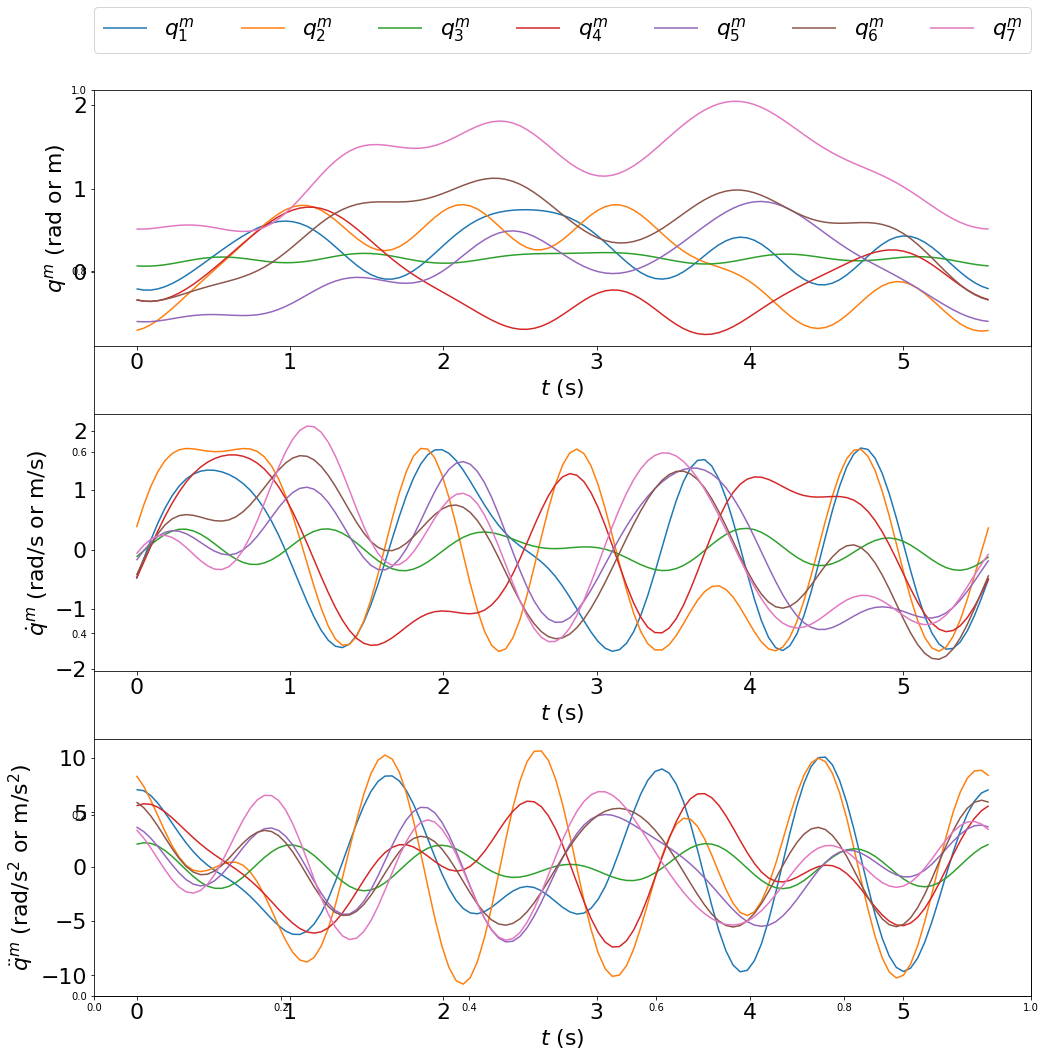

In [6]:
from trajectory_optimization import FourierTraj
fourier_traj_train = FourierTraj(dof, fourier_order, base_freq, sample_num_per_period=20)
traj_plotter_train = TrajPlotter(fourier_traj_train, coordinates=robot_model.coordinates)
traj_plotter_train.plot_desired_traj(traj_optimizer_result)

In [ ]:
test_plot_data_folder = 'data/' + model_name +'/matlabe/traj/'
data_name_mq=training_trajectory_name_+training_trajectory_name+'_ref_traj_per_q'
data_name_mqd=training_trajectory_name_+training_trajectory_name+'_ref_traj_per_qd'
data_name_mqdd=training_trajectory_name_+training_trajectory_name+'_ref_traj_per_qdd'

data_name_mf=training_trajectory_name_+training_trajectory_name+'_ref_traj_full'

data_name_p=training_trajectory_name_+test_trajectory_name+'_ref_traj_per'
data_name_pf=training_trajectory_name_+test_trajectory_name+'_ref_traj_full'

q, dq, ddq = self._fourier_traj.fourier_base_x2q(fourier_x)

save_csv_data(test_plot_data_folder, data_name_p, tau_p_sdp_test[:plot_data_num, :])  #omer
save_csv_data(test_plot_data_folder, data_name_p, tau_p_sdp_test[:plot_data_num, :])  #omer
save_csv_data(test_plot_data_folder, data_name_mf, tau_f_test)  #omer
save_csv_data(test_plot_data_folder, data_name_pf, tau_p_sdp_test)  #omer

### Load test data set

In [7]:
test_trajectory_name = 'six'

results_folder = 'data/' + model_name +'/measured_trajectory/'
test_results_data_file = results_folder + test_trajectory_name + '_results.csv'

trajectory_sampling_rate = 200
t_test, q_raw_test, dq_raw_test, tau_raw_test = load_trajectory_data(test_results_data_file,
                                                                   trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (5999, 21))


## Calculate filter cut-off frequency

In [8]:
# times of the highest frequency in the Fourier series
#fc_mult = 4.0

fc_mult = [5] #(good)
#fc_mult = [8, 8, 5, 3, 4, 4, 4]

#fc_mult = 4
print(base_freq)
fc = np.array(fc_mult)*base_freq* fourier_order 

print(fc)


0.18
[5.4]


## Differentiation and filtering

### Traning data

q_raw shape: (5999, 7)
plot shape: 470


<Figure size 432x288 with 0 Axes>

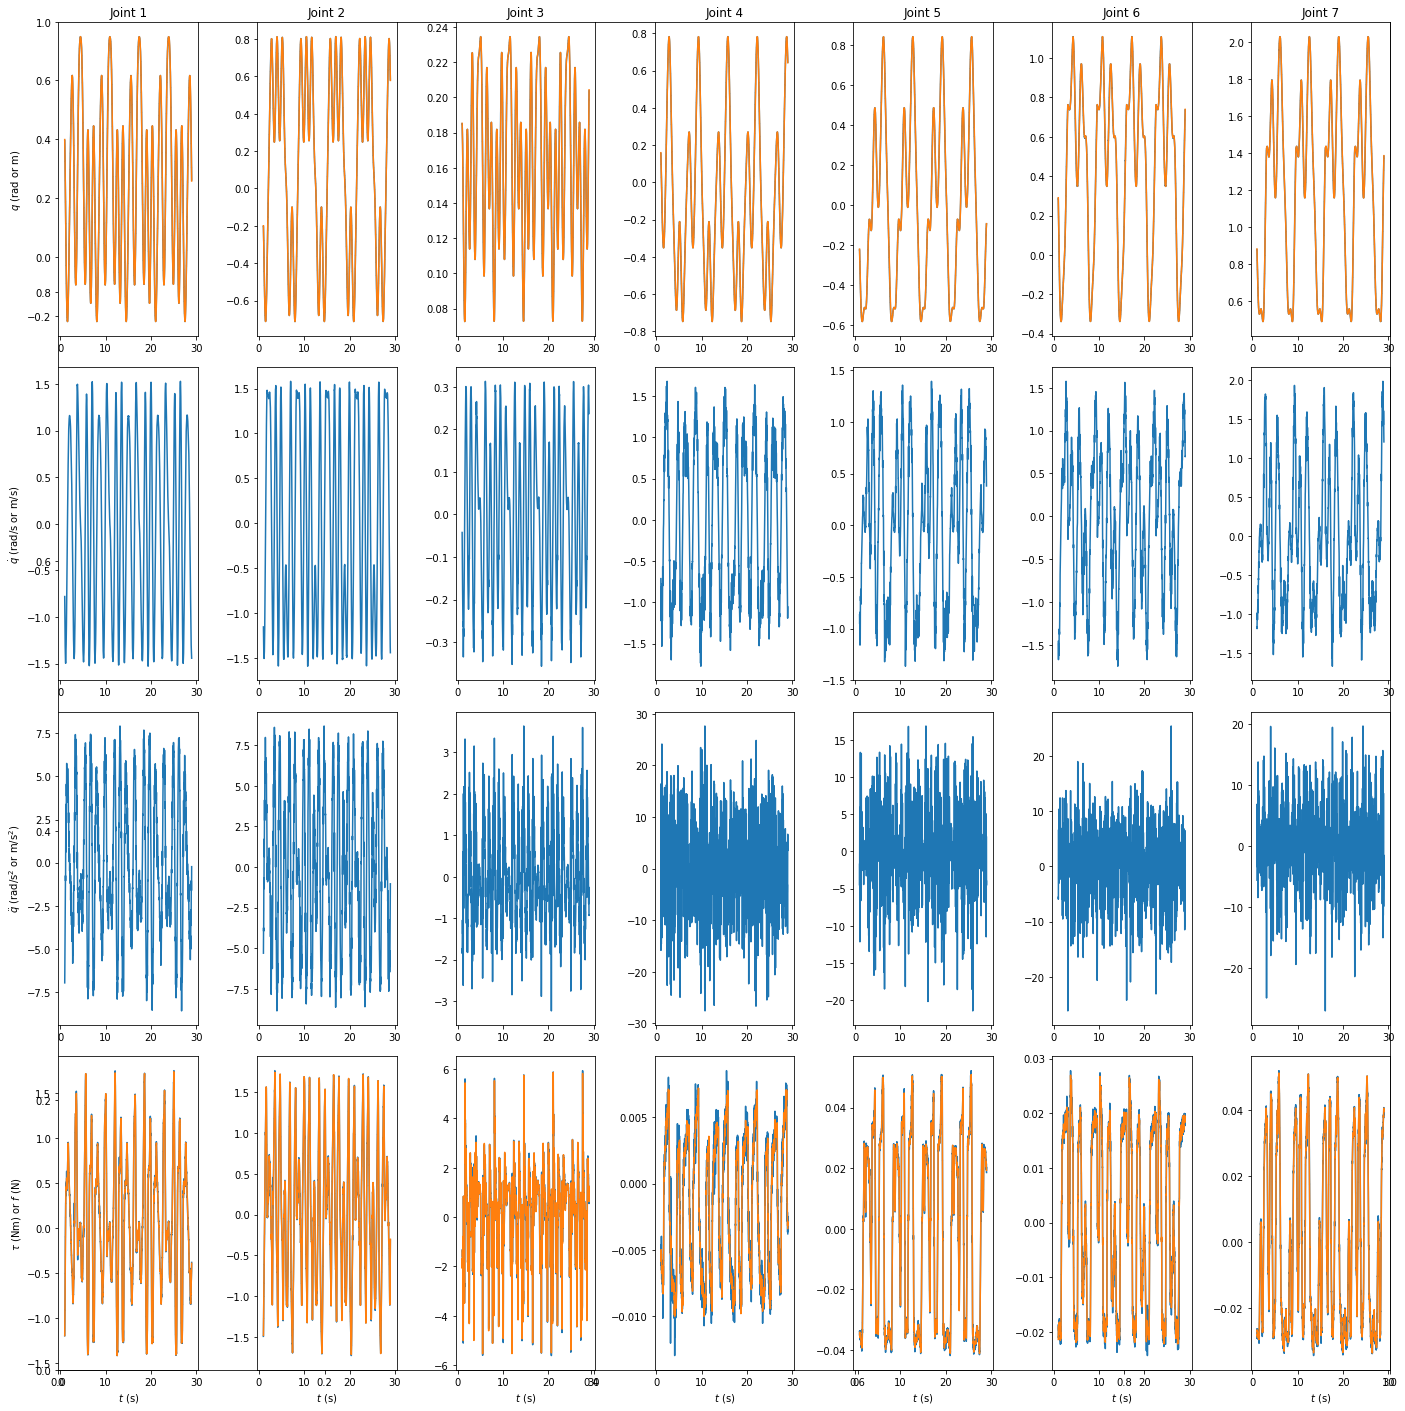

In [9]:
t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_train, q_raw_train, dq_raw_train, tau_raw_train, fc, fc, fc, fc)
plot_trajectory_data(t_cut_train, q_raw_cut_train, q_f_train, dq_f_train, ddq_f_train,
                     tau_raw_cut_train, tau_f_train)

### Test data

q_raw shape: (5999, 7)
plot shape: 470


<Figure size 432x288 with 0 Axes>

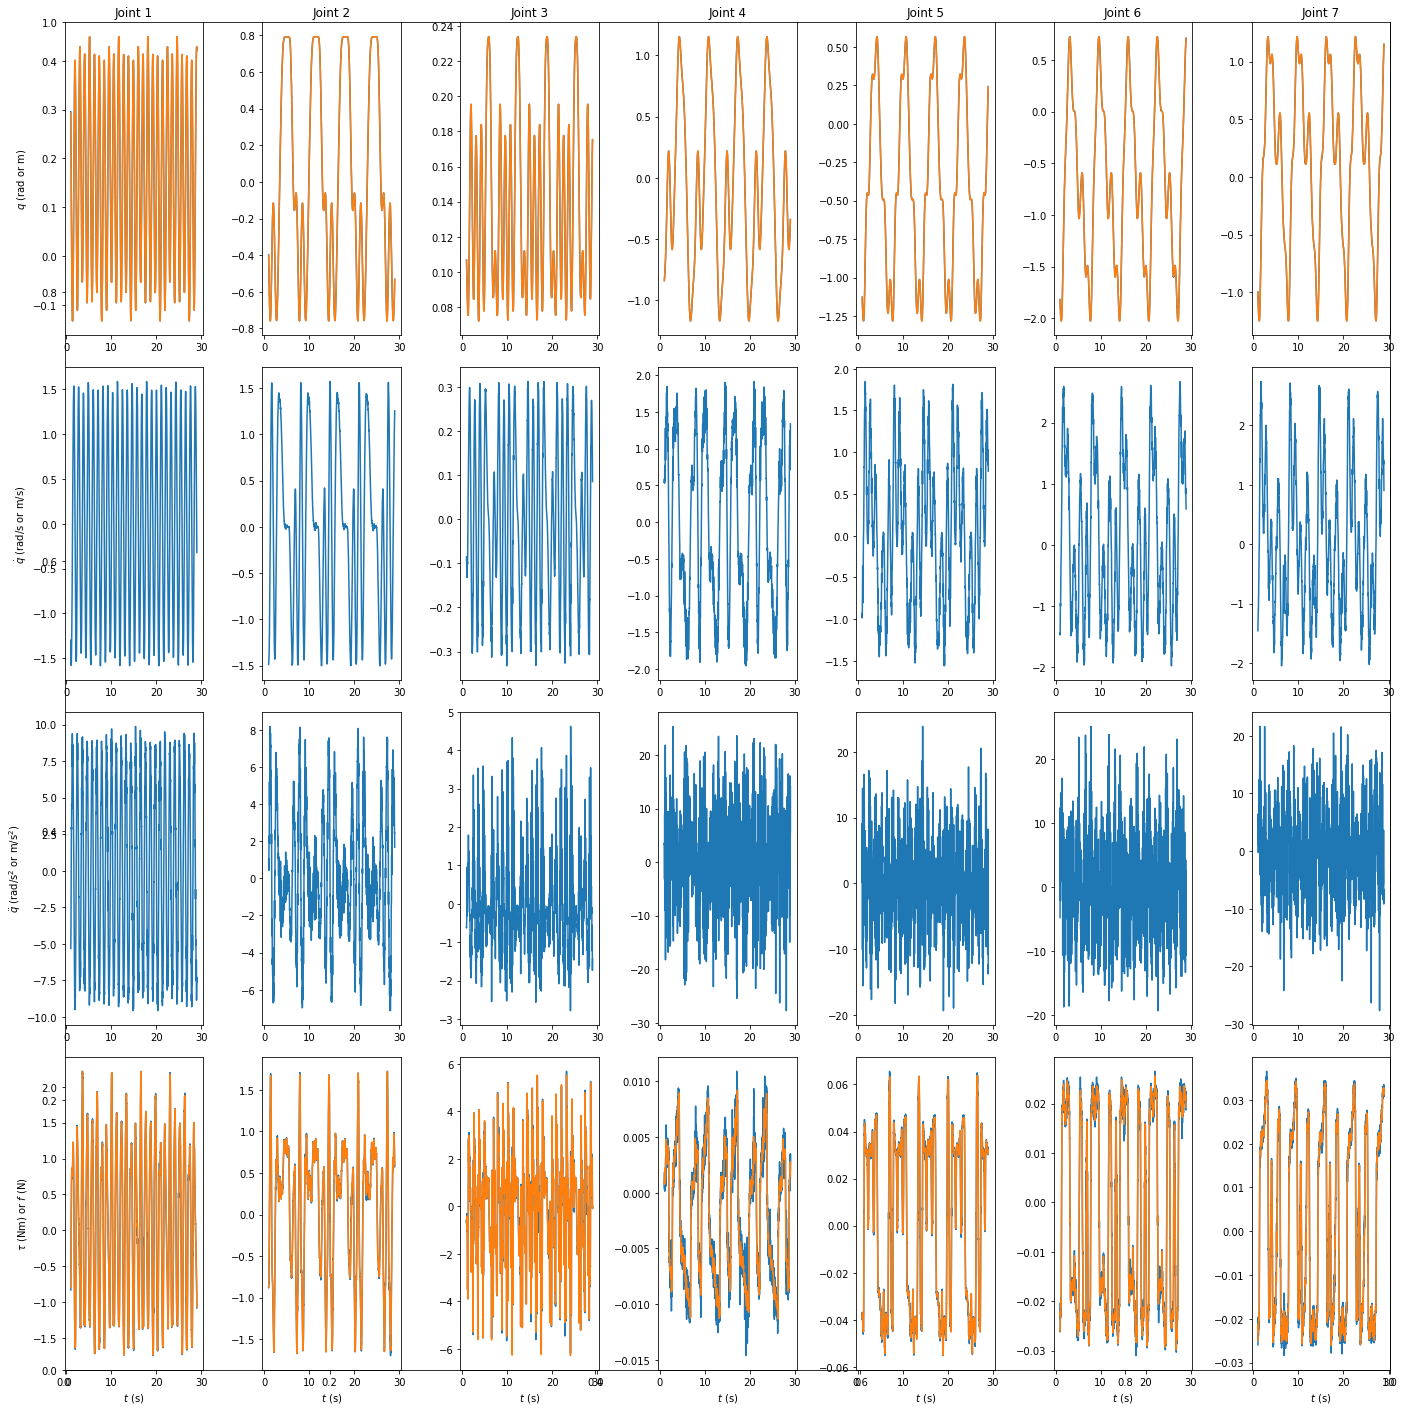

In [10]:
t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_test, q_raw_test, dq_raw_test, tau_raw_test, fc, fc, fc, fc)
plot_trajectory_data(t_cut_test, q_raw_cut_test, q_f_test, dq_f_test, ddq_f_test,
                     tau_raw_cut_test, tau_f_test)

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [11]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b_train, tau_s_train = gen_regressor(base_param_num, H_b_func, q_f_train,
                                       dq_f_train, ddq_f_train, tau_f_train)

In [12]:
W_b_train.shape, tau_s_train.shape
#print np.linalg.cond(W_b_train)

In [13]:
xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]

In [14]:
#sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

from IPython.display import HTML, display
import tabulate

table = [["Base Parameter", "Value"]]

for i in range(robot_model.base_num):
    param_str = str(sympy.Matrix(robot_model.base_param)[i])
    max_disp_len = 350
    line = [param_str if len(param_str) <= max_disp_len 
            else param_str[:max_disp_len] + '...', xb_ols[i]]
    #['%.7s ...'%b if len(str(b)) > 7 else str(b)
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

## Compare measured torque and predicted torque on the training set

### Generate predicted torque

In [15]:
tau_p_train = np.zeros(tau_f_train.shape)
tau_ps_train = W_b_train.dot(xb_ols)
for i in range(dof):
    tau_p_train[:, i] = tau_ps_train[i::dof]
    

### Evaluate regression

In [16]:
var_regression_error_ols = np.linalg.norm(tau_ps_train - tau_s_train) / \
                        (tau_ps_train.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols *
                                 np.linalg.inv(W_b_train.transpose().dot(W_b_train))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.0015994507093644614
standard deviation of xb using OLS:
[9.77156049e-05 1.20070104e-04 8.05065113e-05 9.79577274e-05
 3.71248826e-04 1.43557397e-04 6.35658051e-05 1.24230656e-04
 1.09184643e-04 1.27736681e-04 1.51781927e-04 5.18487204e-05
 5.25277122e-05 5.69139824e-05 5.34152892e-05 7.53408497e-04
 1.02191211e-04 2.72513446e-04 9.54767460e-05 7.85644095e-05
 6.21659788e-05 2.47608293e-04 2.19413437e-03 3.77717313e-04
 6.02648180e-05 1.44345353e-04 1.77587837e-03 8.31850331e-05
 9.90112456e-05 6.83349450e-04 6.54611201e-03 3.59027675e-04
 2.57543674e-02 3.70477018e-04 1.74075943e-03 1.14889742e-03
 3.37367185e-04 1.03774863e-03 2.06662650e-04 2.87643392e-04
 2.34509263e-04 4.02667347e-03 1.17750010e-03 1.72186350e-03
 7.24632481e-03 1.45255856e-03 1.49246434e-03 2.16525947e-02
 1.30694028e-03 1.15231977e-03 1.44777641e-03 1.23233491e-03
 1.24410073e-03 6.11019077e-04 1.54704356e-04 7.47783901e-03
 2.97789381e-01 6.64757233e-04 7.71357708e-03 8.

### Plot measured torque and predicted torque

('Avarage error of joint ', 1, ': ', 0.0766246753066953)
('Avarage error of joint ', 2, ': ', 0.12306922861594653)
('Avarage error of joint ', 3, ': ', 0.5605374085067314)
('Avarage error of joint ', 4, ': ', 0.03775862688900664)
('Avarage error of joint ', 5, ': ', 0.05548129329971269)
('Avarage error of joint ', 6, ': ', 0.013448540100244086)
('Avarage error of joint ', 7, ': ', 0.01725905092865241)
('Avarage of error: ', 0.12631126052099845)


<Figure size 432x288 with 0 Axes>

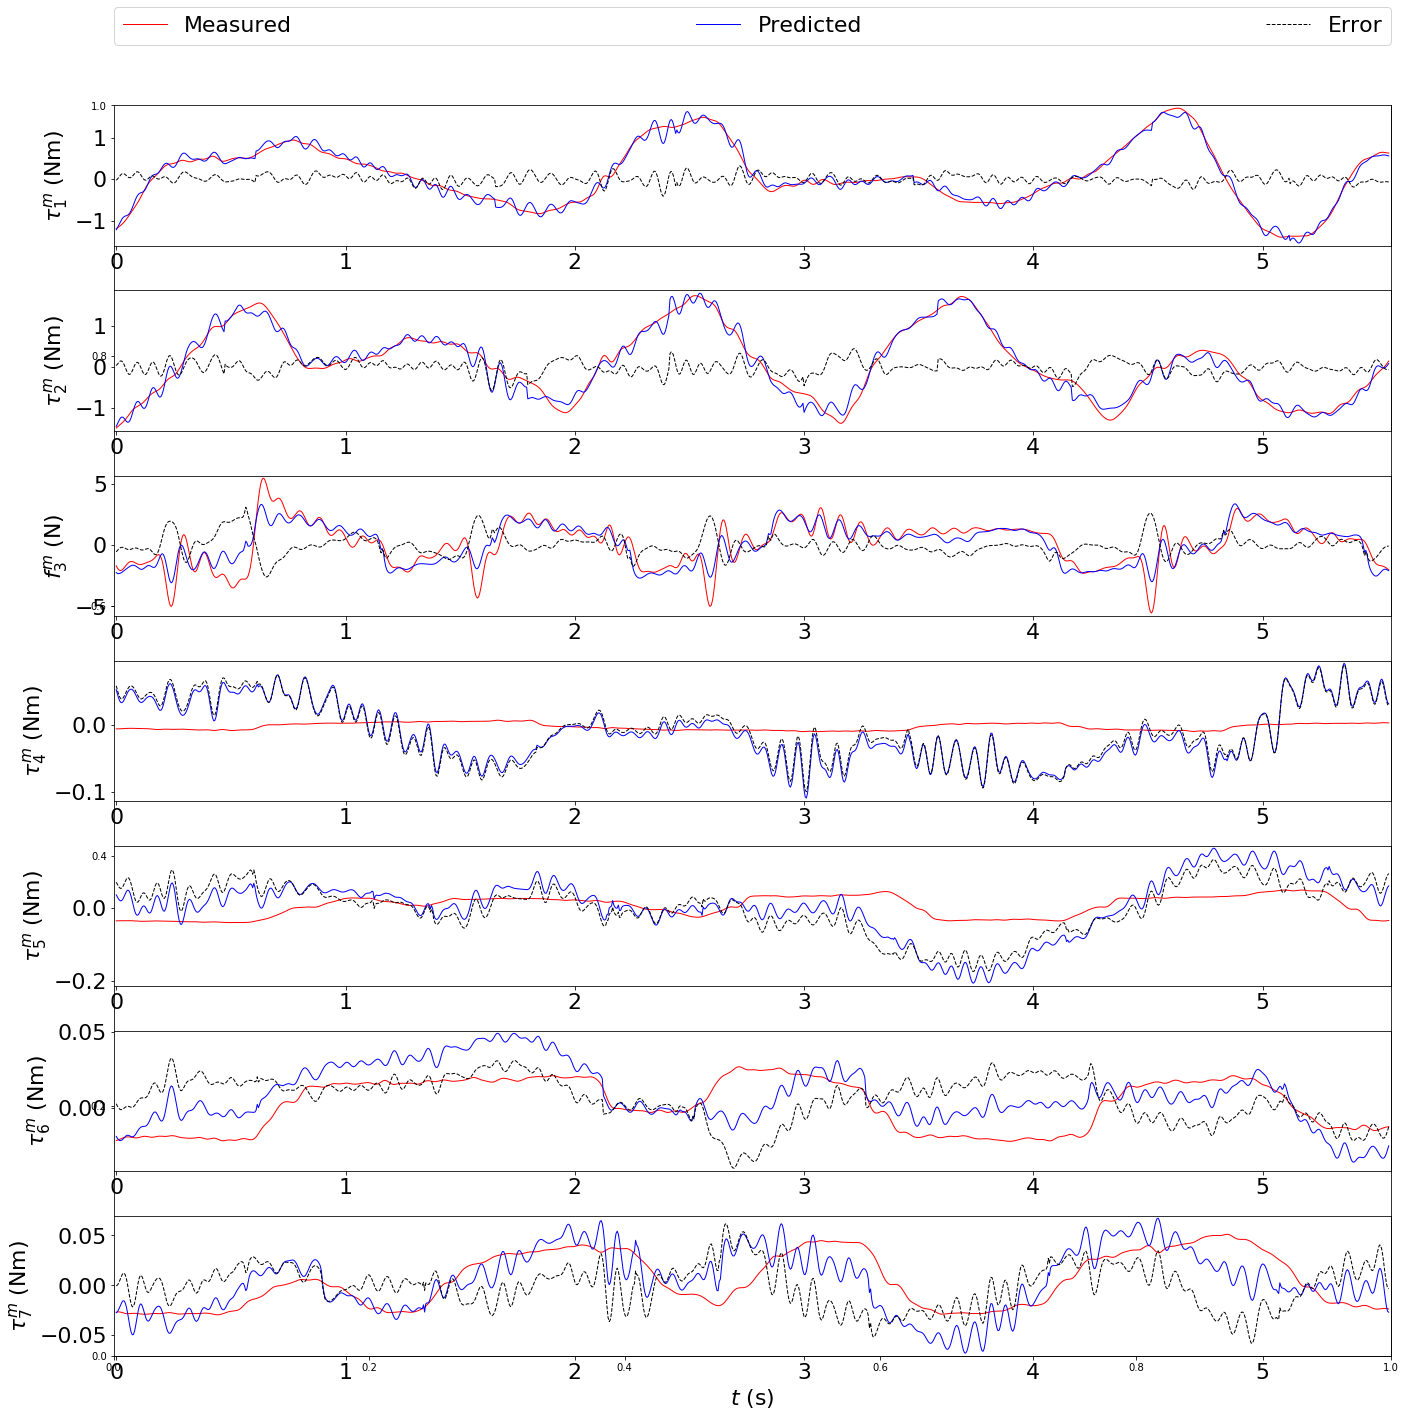

In [17]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on the test set

In [18]:
W_b_test, tau_s_test = gen_regressor(base_param_num, H_b_func, q_f_test,
                                       dq_f_test, ddq_f_test, tau_f_test)

tau_p_test = np.zeros(tau_f_test.shape)
tau_ps_test = W_b_test.dot(xb_ols)
for i in range(dof):
    tau_p_test[:, i] = tau_ps_test[i::dof]

('Avarage error of joint ', 1, ': ', 0.14399725200128988)
('Avarage error of joint ', 2, ': ', 0.1799187625504248)
('Avarage error of joint ', 3, ': ', 0.6463561631008277)
('Avarage error of joint ', 4, ': ', 0.04527148394500923)
('Avarage error of joint ', 5, ': ', 0.10172267131997184)
('Avarage error of joint ', 6, ': ', 0.025937623204910425)
('Avarage error of joint ', 7, ': ', 0.026142072661198935)
('Avarage of error: ', 0.1670494326833761)


<Figure size 432x288 with 0 Axes>

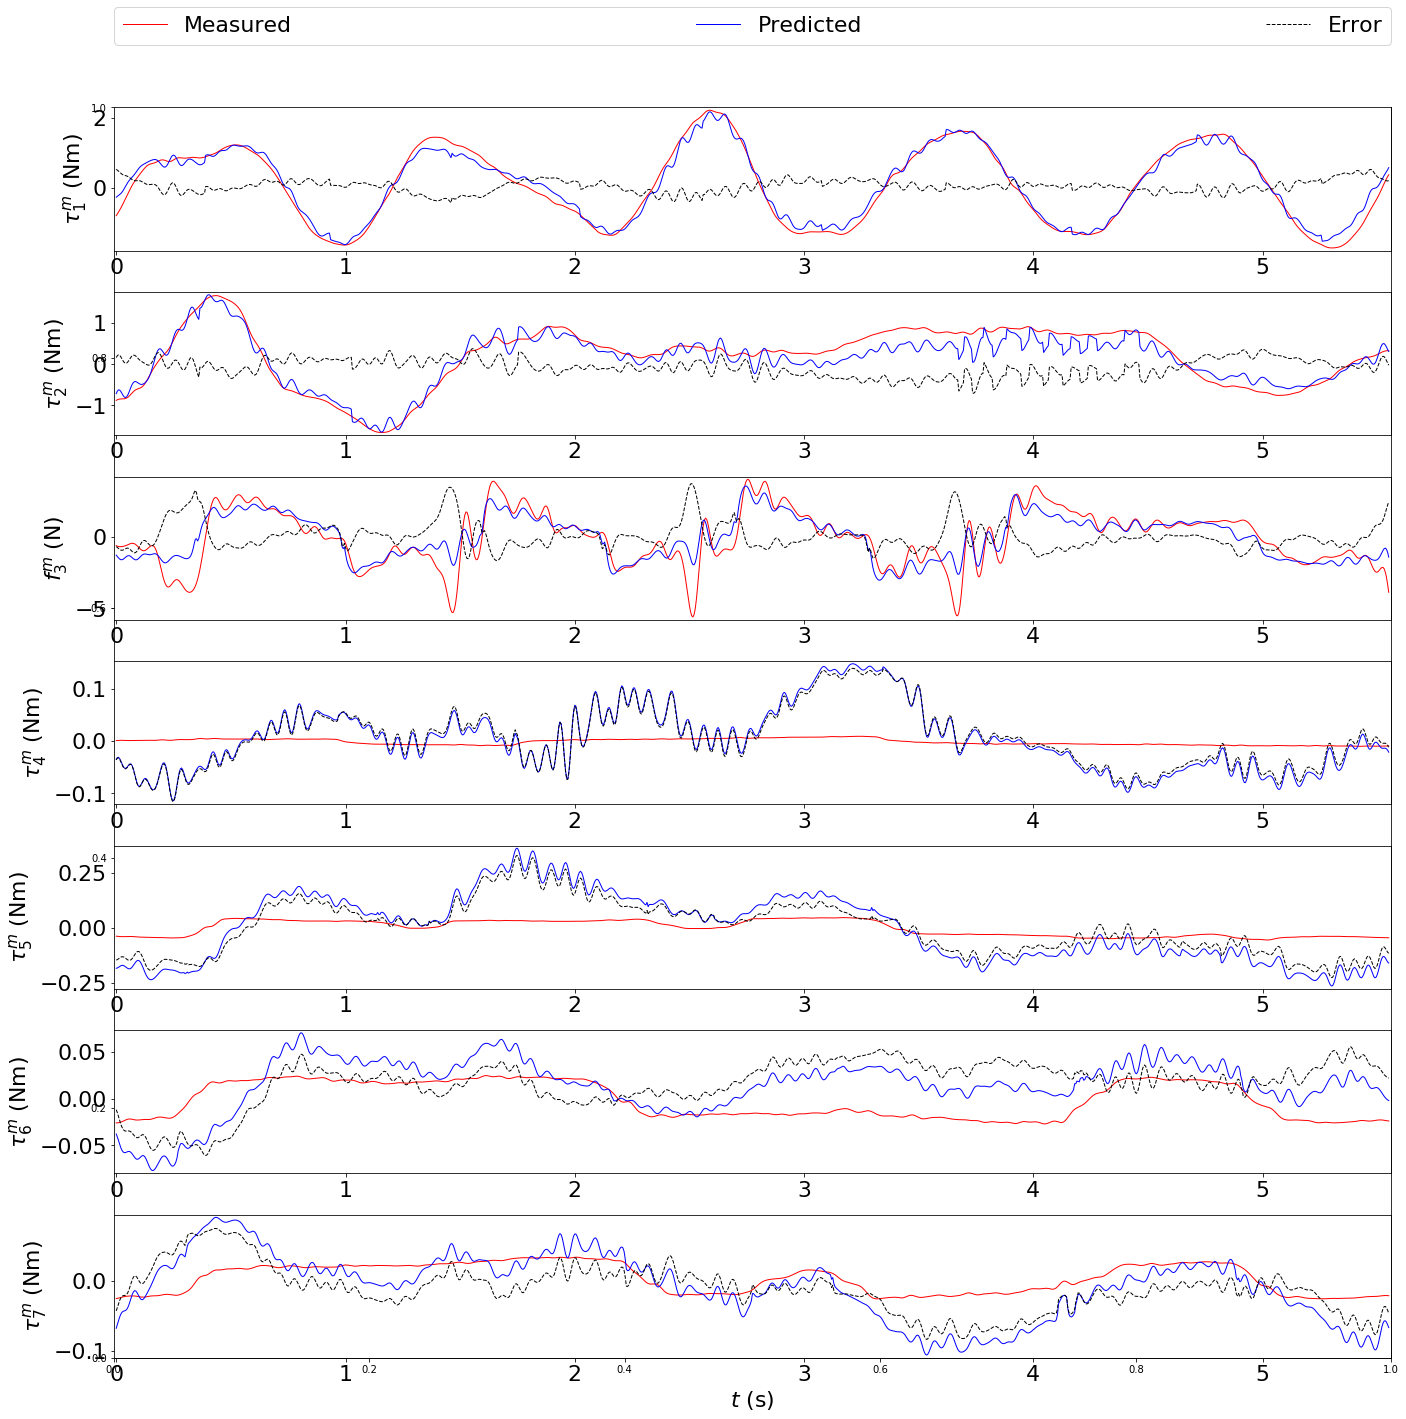

In [19]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [20]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_test[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.16597502, 0.30218482, 0.48488419, 9.49982873, 3.40700545,
       1.53824152, 1.63467408])

## Weighted Least Square (WLS)

### Training data set

In [21]:
# weight = np.sqrt(np.linalg.norm(tau_f - tau_p, axis=0)/(tau_f.shape[0] - base_param_num))
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)
weight

array([ 3.14553446,  3.46406447, 11.40337965,  0.01725339,  0.09212086,
        0.04917259,  0.08463814])

In [22]:
W_b_train.shape, tau_s_train.shape

In [23]:
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_train.shape[0]/weight.shape[0])

In [24]:
W_b_wls_train = np.multiply(W_b_train, np.asmatrix(weights).transpose())
tau_s_wls_train = np.multiply(tau_s_train, weights)

In [25]:
xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]

In [26]:
#np.set_printoptions(precision=2)
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_wls))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [27]:
tau_p_wls_train = np.zeros(tau_f_train.shape)
tau_ps_wls_train = W_b_train.dot(xb_wls)
for i in range(dof):
    tau_p_wls_train[:, i] = tau_ps_wls_train[i::dof]

('Avarage error of joint ', 1, ': ', 0.07336601065380723)
('Avarage error of joint ', 2, ': ', 0.12109618140753163)
('Avarage error of joint ', 3, ': ', 0.5689086803396651)
('Avarage error of joint ', 4, ': ', 0.0007376870066795628)
('Avarage error of joint ', 5, ': ', 0.01163168328696541)
('Avarage error of joint ', 6, ': ', 0.004334517976158596)
('Avarage error of joint ', 7, ': ', 0.008423926246674898)
('Avarage of error: ', 0.11264266955964033)


<Figure size 432x288 with 0 Axes>

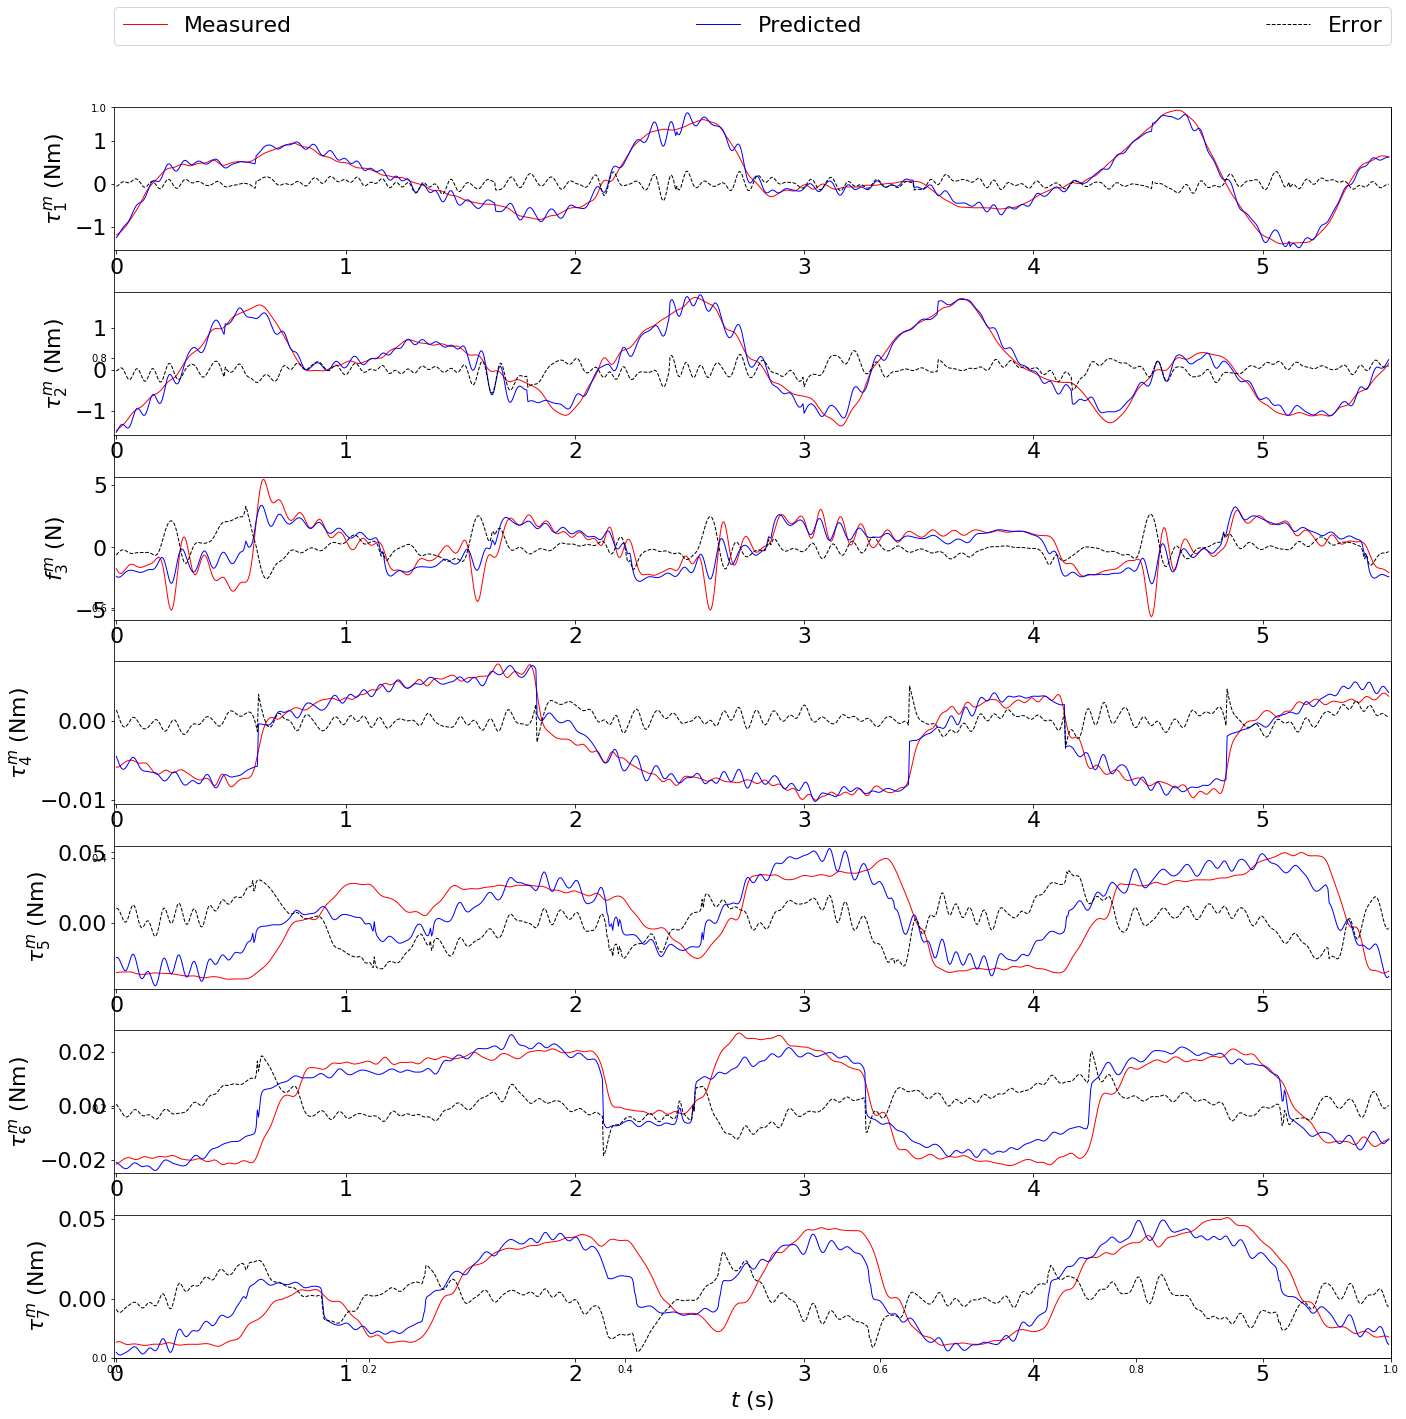

In [28]:
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_wls_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type, 
                   robot_model.coordinates)

In [29]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_wls_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.13019032, 0.18957637, 0.46050546, 0.16774428, 0.49545198,
       0.32445054, 0.39717753])

### Test data set

('Avarage error of joint ', 1, ': ', 0.10030582254759066)
('Avarage error of joint ', 2, ': ', 0.1498419771668489)
('Avarage error of joint ', 3, ': ', 0.6332994258685816)
('Avarage error of joint ', 4, ': ', 0.00370896346556233)
('Avarage error of joint ', 5, ': ', 0.014845523174757952)
('Avarage error of joint ', 6, ': ', 0.003960946111592608)
('Avarage error of joint ', 7, ': ', 0.01185624749210702)
('Avarage of error: ', 0.13111698654672016)


<Figure size 432x288 with 0 Axes>

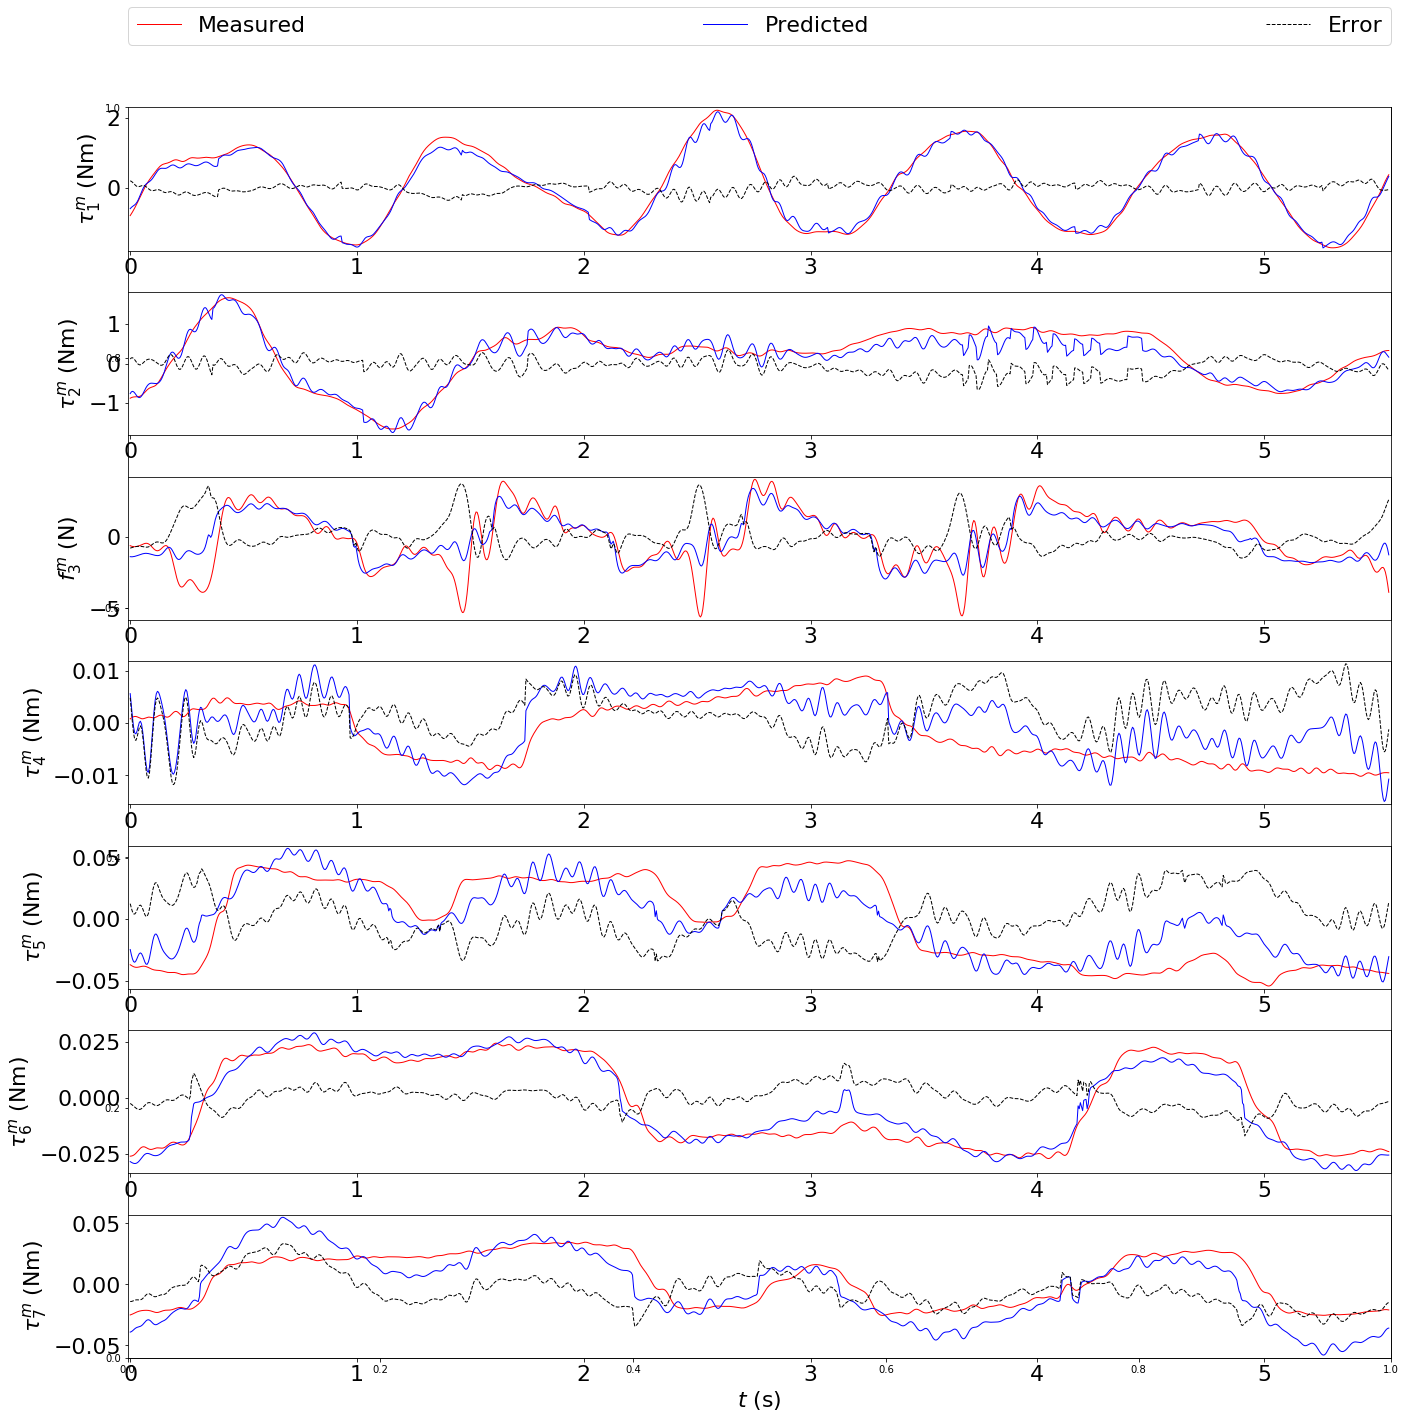

In [30]:
weight = np.max(tau_f_test, axis=0) - np.min(tau_f_test, axis=0)

# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_test.shape[0]/weight.shape[0])

W_b_wls_test = np.multiply(W_b_test, np.asmatrix(weights).transpose())
tau_s_wls_test = np.multiply(tau_s_test, weights)

tau_p_wls_test = np.zeros(tau_f_test.shape)
tau_ps_wls_test = W_b_test.dot(xb_wls)
for i in range(dof):
    tau_p_wls_test[:, i] = tau_ps_wls_test[i::dof]

plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_wls_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [31]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_wls_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.11721656, 0.26181139, 0.49070637, 0.74125298, 0.52250751,
       0.25202912, 0.68309396])

## Convex optimization

### Generate regressor matrix for barycentric parameters

In [32]:
from identification import SDPOpt
from identification import ALPSOOpt


bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_train, tau_s_train = gen_regressor(bary_param_num, H_func,
                                     q_f_train, dq_f_train, ddq_f_train, tau_f_train)

In [33]:
W_w_train = np.multiply(W_train, np.asmatrix(weights).transpose())
tau_w_s_train = np.multiply(tau_s_train, weights)

min $m$, max $m$, min $r_x$, max $r_x$, min $r_y$, max $r_y$, min $r_z$, max $r_z$, max $F_c$, max $F_v$, max $F_o$, min $K$, max $K$

In [34]:
sdp_constraints = []
spring_constraints = []

if model_name == 'psm':
    sdp_constraints = [(0.3, 10, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, 0.3, 0.5, 0.3, 1, 0, 2), #yaw_link
                       (0.3, 10, -0.1, 0.1, -0.2, 0.1, -0.05, 0.05, 0.3, 0.5, 0.2, 1, 0, 2),    #Pitch Back
                       (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0), #Intermediate
                       (0.1, 5, 0.1, 0.4, -0.06, 0.02, -0.03, 0.03, 0.3, 0.5, 0.2, 1, 0, 2), #Pitch Bottom
                       (0.05, 4, 0.0, 0.05, -0.40, 0.05, -0.03, 0.03, 0.3, 0.5, 0.2, 1, 0, 2), #Pitch End
                       (0.05, 5, -0.02, 0.02, -0.02, 0.02, -0.1, 0.15, 0.6, 2, 0.2, 1, 0, 2), #Main Insertion
                       (0, 2, -0.05, 0.05, -0.05, 0.05, -0.1, 0.1, 0.2, 0.2, 0.2, 1, 0.0001, 2), # Wrist Roll
                       (0, 1, -0.05, 0.05, -0.05, 0.05, -0.05, 0.05, 0.2, 0.2, 0.2, 1, 0, 2), # Wrist Pitch
                       (0, 0.3, -0.05, 0.05, -0.05, 0.05, -0.05, 0.05, 0.2, 0.2, 0.2, 1, 0, 2), # Wrist Yaw1
                       (0, 0.1, -0.05, 0.05, -0.05, 0.05, -0.05, 0.05, 0.2, 0.2, 0.2, 1, 0, 2),
                       (0.1, 2, -0.05, 0.05, -0.03, 0.03, -0.1, 0.1, 0.2, 0.5, 0.2, 1, 0, 2) ] # #Counterweight
    #sdp_constraints = [(0.3, 10, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, 0.3, 0.5, 0.3, 1, 0, 0), #yaw_link
                      #(0.3, 10, -0.1, 0.1, -0.2, 0.1, -0.05, 0.05, 0.3, 0.5, 0.2, 1, 0, 0),    #Pitch Back
                      #(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0), #Intermediate
                      #(0.1, 5, 0.1, 0.4, -0.06, 0.02, -0.03, 0.03, 0.3, 0.5, 0.2, 1, 0, 0), #Pitch Bottom
                      #(0.02, 2, 0.1, 0.4, -0.03, 0.03, -0.03, 0.03, 0.3, 0.5, 0.2, 1, 0, 0), #Pitch Top
                      #(0.1, 5, 0.0, 0.05, -0.40, 0.05, -0.03, 0.03, 0.3, 0.5, 0.2, 1, 0, 0), #Pitch End
                      #(0.01, 0.5, -0.05, 0.0, -0.14, 0.0, 0.02, 0.08, 0.3, 0.5, 0.2, 1, 0, 0),  #Pitch Front
                      #(0.1, 2, -0.02, 0.02, -0.02, 0.02, -0.1, 0.15, 0.6, 2, 0.2, 1, 0, 0), #Main Insertion
                      #(0.1, 2, -0.05, 0.05, -0.03, 0.03, -0.1, 0.1, 0.2, 0.5, 0.2, 1, 0, 0), #Counterweight
                      #(0, 1, -0.05, 0.05, -0.05, 0.05, -0.1, 0.1, 0.2, 0.2, 0.2, 1, 0.0001, 1), # Wrist Roll
                      #(0, 1, -0.05, 0.05, -0.05, 0.05, -0.05, 0.05, 0.2, 0.2, 0.2, 1, 0, 0), # Wrist Pitch
                      #(0, 1, -0.05, 0.05, -0.05, 0.05, -0.05, 0.05, 0.2, 0.2, 0.2, 1, 0, 0), # Wrist Yaw1
                      #(0, 1, -0.05, 0.05, -0.05, 0.05, -0.05, 0.05, 0.2, 0.2, 0.2, 1, 0, 0), # Wrist Yaw2
                      #(0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 1, 0, 0), # M6
                      #(0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 1, 0, 0), # M7
                      #(0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 1, 0, 0)] # F67

else:
    raise Exception("No robot name matches " + model_name)

In [35]:
sdp_opt_std = SDPOpt(W_w_train, tau_w_s_train, robot_model, sdp_constraints)
%time sdp_opt_std.solve(20000)

Regressor shape: (39193, 149)
Regressand shape: (39193,)
Creating variables...
Creating optimization objective...
Creating constraints...
Solving problem...
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1719291, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 20000, normalize = 1, scale = 1.00
Variables n = 150, constraints m = 39473
Cones:	linear vars: 178
	soc vars: 39195, soc blks: 1
	sd vars: 100, sd blks: 10
Setup time: 1.10e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf      -inf       inf  4.30e-0

  9400| 2.91e-01  2.87e-03  6.68e-04  9.07e+01  9.08e+01  6.14e-14  2.25e+03 
  9500| 2.90e-01  3.85e-03  6.78e-04  9.15e+01  9.17e+01  6.25e-14  2.27e+03 
  9600| 2.90e-01  1.83e-03  6.41e-04  9.24e+01  9.25e+01  6.36e-14  2.29e+03 
  9700| 2.90e-01  2.24e-03  5.83e-04  9.32e+01  9.33e+01  6.47e-14  2.31e+03 
  9800| 2.89e-01  3.81e-03  5.47e-04  9.40e+01  9.41e+01  6.57e-14  2.33e+03 
  9900| 2.89e-01  2.36e-03  5.60e-04  9.49e+01  9.50e+01  3.34e-14  2.35e+03 
 10000| 2.88e-01  1.59e-03  5.92e-04  9.57e+01  9.58e+01  3.40e-14  2.37e+03 
 10100| 2.88e-01  3.56e-03  6.10e-04  9.65e+01  9.66e+01  3.45e-14  2.39e+03 
 10200| 2.87e-01  2.76e-03  5.92e-04  9.73e+01  9.74e+01  3.51e-14  2.41e+03 
 10300| 2.87e-01  1.24e-03  5.40e-04  9.81e+01  9.83e+01  3.57e-14  2.43e+03 
 10400| 2.86e-01  3.23e-03  4.99e-04  9.90e+01  9.91e+01  3.62e-14  2.45e+03 
 10500| 2.86e-01  3.01e-03  4.94e-04  9.98e+01  9.99e+01  3.68e-14  2.47e+03 
 10600| 2.86e-01  1.08e-03  5.16e-04  1.01e+02  1.01e+02  3.74e-

 20000| 2.48e-01  1.40e-03  1.17e-04  1.67e+02  1.67e+02  5.39e-14  4.05e+03 
----------------------------------------------------------------------------
Status: Solved/Inaccurate
Hit max_iters, solution may be inaccurate
Timing: Solve time: 4.05e+03s
	Lin-sys: avg # CG iterations: 70.93, avg solve time: 2.01e-01s
	Cones: avg projection time: 2.77e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 7.9652e-08, dist(y, K*) = 2.9017e-09, s'y/|s||y| = 3.2850e-11
|Ax + s - b|_2 / (1 + |b|_2) = 2.4816e-01
|A'y + c|_2 / (1 + |c|_2) = 1.4046e-03
|c'x + b'y| / (1 + |c'x| + |b'y|) = 1.1669e-04
----------------------------------------------------------------------------
c'x = 166.8375, -b'y = 166.8766
CPU times: user 8h 50min, sys: 7min 58s, total: 8h 57min 58s
Wall time: 1h 7min 28s


In [36]:
from identification import ALPSOOpt

In [37]:
#alpso_opt_std = ALPSOOpt(W_w_train, tau_w_s_train, robot_model, sdp_constraints)
#%time alpso_opt_std.solve()

## Compare measured torque and predicted torque on training set

### Generate predicted torque

In [38]:
tau_p_sdp_train = np.zeros(tau_f_train.shape)
tau_ps_sdp_train = W_train.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_train[:, i] = tau_ps_sdp_train[i::dof]

In [39]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_sdp_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.14117599, 0.19204075, 0.5140088 , 0.20099178, 0.49700652,
       0.32646322, 0.38551679])

### Plot measured torque and predicted torque

('Avarage error of joint ', 1, ': ', 0.08066337233086632)
('Avarage error of joint ', 2, ': ', 0.12265254906748993)
('Avarage error of joint ', 3, ': ', 0.6113377943183375)
('Avarage error of joint ', 4, ': ', 0.0009022704924031599)
('Avarage error of joint ', 5, ': ', 0.01169362598662874)
('Avarage error of joint ', 6, ': ', 0.004367369351903945)
('Avarage error of joint ', 7, ': ', 0.008211246278411135)
('Avarage of error: ', 0.11997546111800583)


<Figure size 432x288 with 0 Axes>

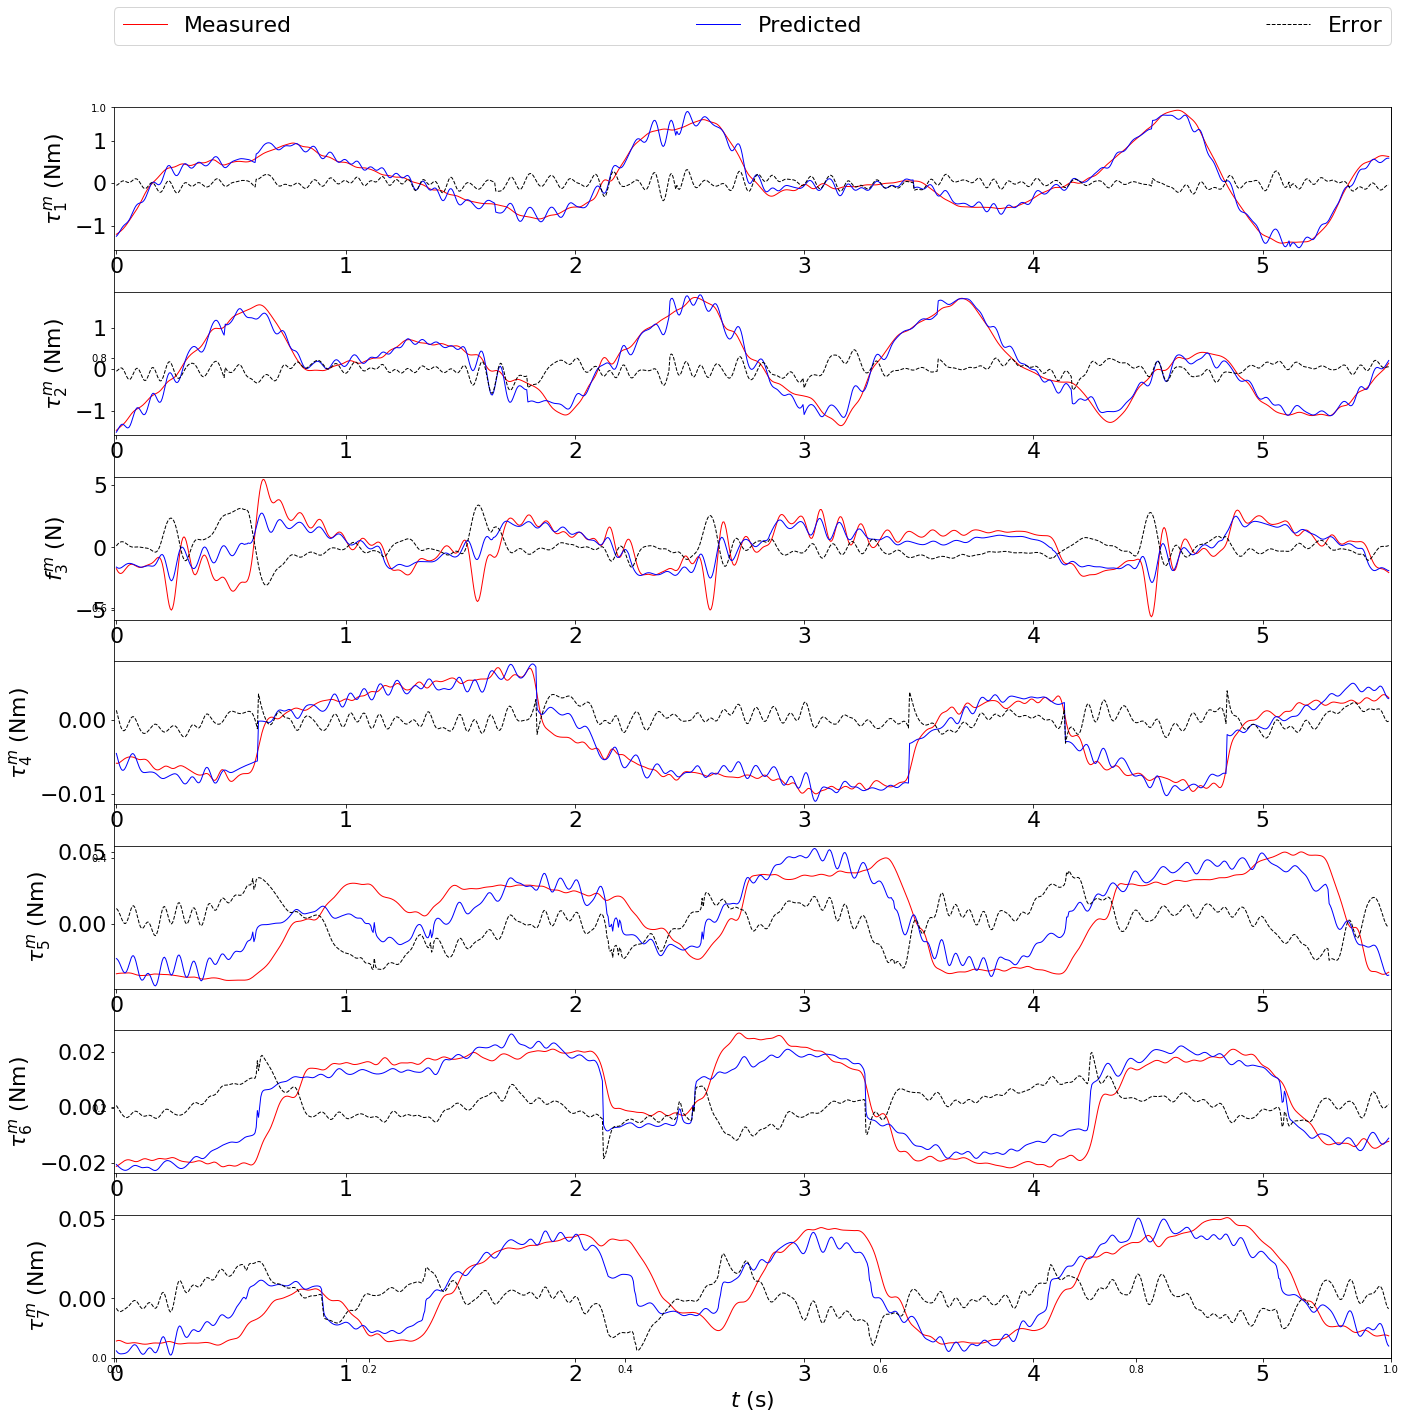

In [40]:
test_plot_data_folder = 'data/' + model_name +'/matlabe/'
data_name_m= training_trajectory_name_+training_trajectory_name+'_new_cvx_tau_m_train'
data_name_p= training_trajectory_name_+training_trajectory_name+'_new_cvx_tau_p_train'
data_name_mf= training_trajectory_name_+training_trajectory_name+'_new_cvx_tau_mf_train'
data_name_pf= training_trajectory_name_+training_trajectory_name+'_new_cvx_tau_pf_train'
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num] - t_cut_train[0],
                   tau_f_train[:plot_data_num, :],
                   tau_p_sdp_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

save_csv_data(test_plot_data_folder, data_name_m, tau_f_train[:plot_data_num, :])  #omer
save_csv_data(test_plot_data_folder, data_name_p, tau_p_sdp_train[:plot_data_num, :])  #omer
save_csv_data(test_plot_data_folder, data_name_mf, tau_f_train)  #omer
save_csv_data(test_plot_data_folder, data_name_pf, tau_p_sdp_train)  #omer

## Compare measured torque and predicted torque on test set

In [41]:
bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_test, tau_s_test = gen_regressor(bary_param_num, H_func,
                                   q_f_test, dq_f_test, ddq_f_test, tau_f_test)

('Avarage error of joint ', 1, ': ', 0.08809777457781016)
('Avarage error of joint ', 2, ': ', 0.16423259459778006)
('Avarage error of joint ', 3, ': ', 0.7113253741017896)
('Avarage error of joint ', 4, ': ', 0.003629131638279746)
('Avarage error of joint ', 5, ': ', 0.014662197883925102)
('Avarage error of joint ', 6, ': ', 0.004038240027914768)
('Avarage error of joint ', 7, ': ', 0.011903225004480692)
('Avarage of error: ', 0.14255550540456857)


<Figure size 432x288 with 0 Axes>

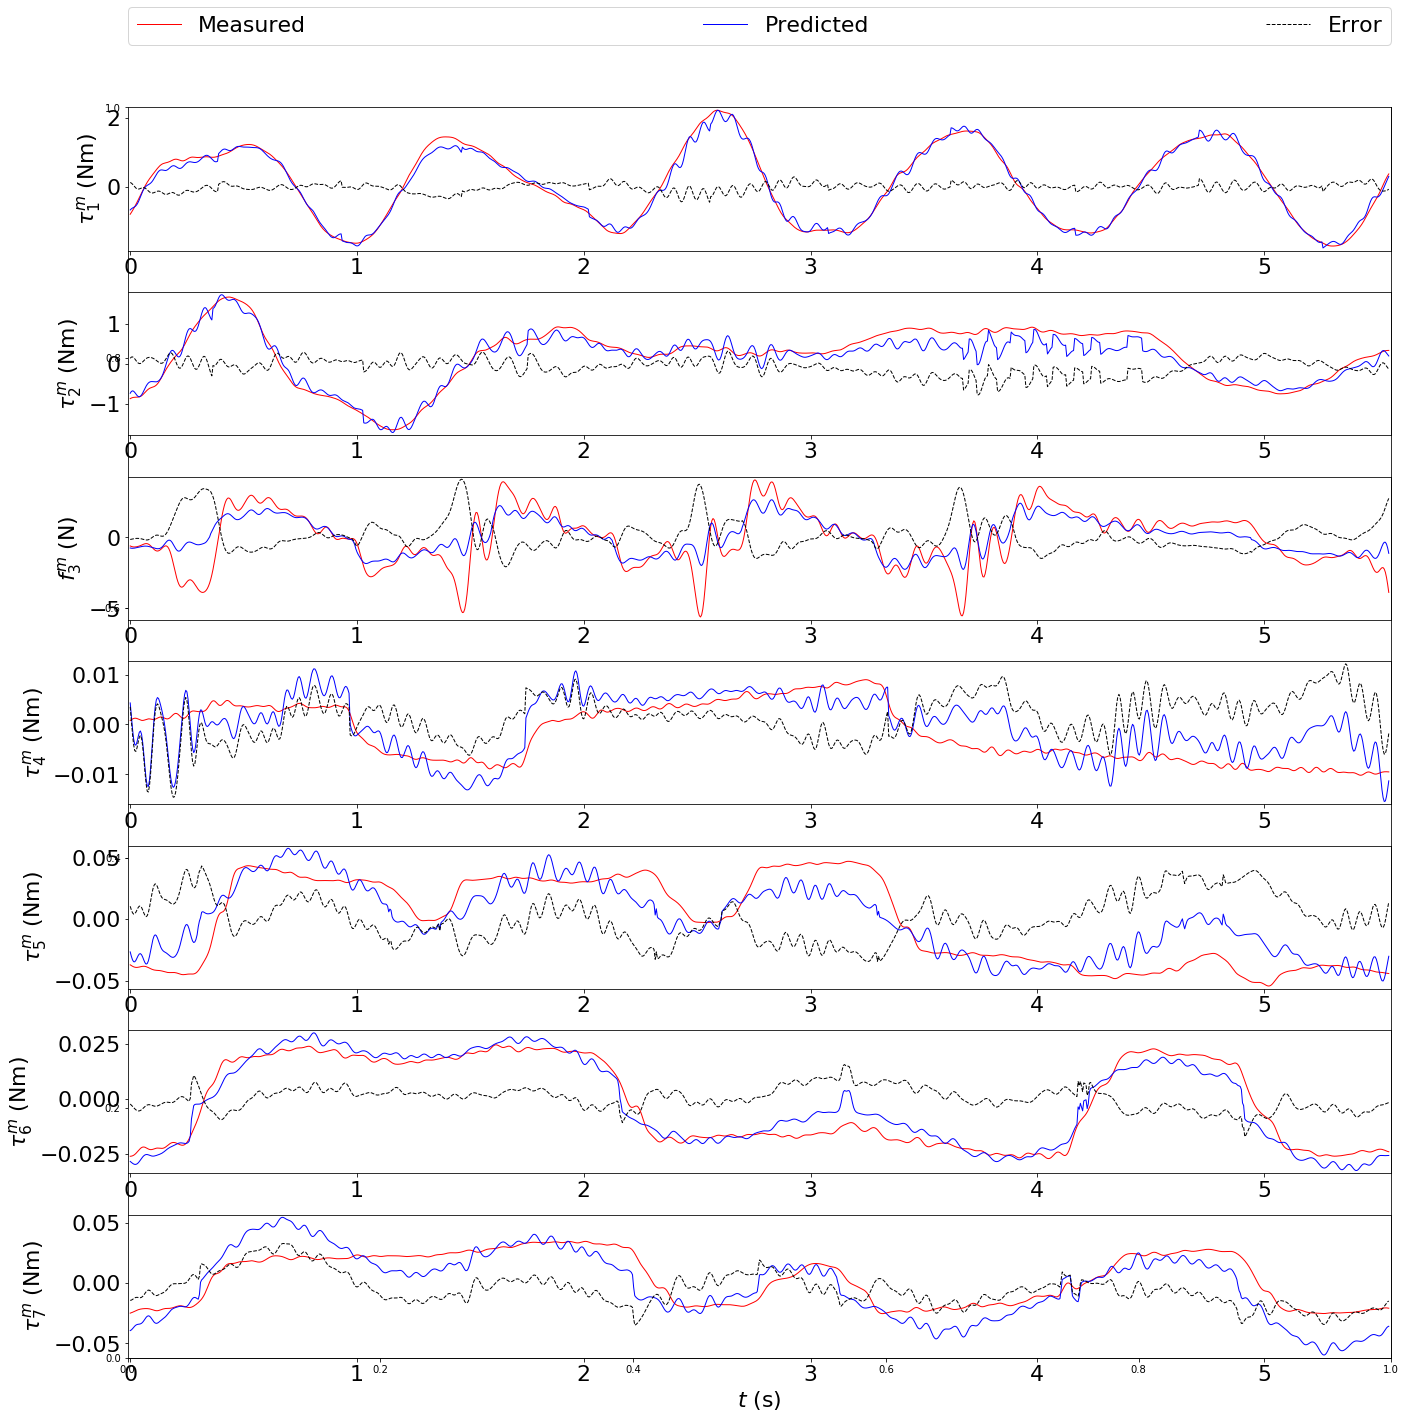

In [42]:
tau_p_sdp_test = np.zeros(tau_f_test.shape)
tau_ps_sdp_test = W_test.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_test[:, i] = tau_ps_sdp_test[i::dof]
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [43]:
test_plot_data_folder = 'data/' + model_name +'/matlabe/'
data_name_m=training_trajectory_name_+test_trajectory_name+'_new_cvx_tau_m_test'
data_name_p=training_trajectory_name_+test_trajectory_name+'_new_cvx_tau_p_test'
data_name_mf=training_trajectory_name_+test_trajectory_name+'_new_cvx_tau_mf_test'
data_name_pf=training_trajectory_name_+test_trajectory_name+'_new_cvx_tau_pf_test'

test_plot_data = (t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)
save_data(test_plot_data_folder, test_trajectory_name, test_plot_data)
save_csv_data(test_plot_data_folder, test_trajectory_name, test_plot_data)  #omer
save_csv_data(test_plot_data_folder, data_name_m, tau_f_test[:plot_data_num, :])  #omer
save_csv_data(test_plot_data_folder, data_name_p, tau_p_sdp_test[:plot_data_num, :])  #omer
save_csv_data(test_plot_data_folder, data_name_mf, tau_f_test)  #omer
save_csv_data(test_plot_data_folder, data_name_pf, tau_p_sdp_test)  #omer

In [44]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_sdp_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.10756234, 0.28667043, 0.54743074, 0.73904072, 0.51626785,
       0.25449234, 0.68864821])

In [45]:
from identification import params_array2table
x_bary_round= np.around(sdp_opt_std.x_result, decimals=7)
bary_param_table = params_array2table(x_bary_round, robot_model, 'bary')
# sympy.Matrix.hstack(sympy.Matrix(robot_model.bary_param), sympy.Matrix(sdp_opt_std.x_result))
bary_param_table

⎡link     Lₓₓ         L_xy        L_xz        L_yy        L_yz        L_zz    
⎢                                                                             
⎢ 1    0.9945542   0.0005335      0.0       0.995481      0.0      0.0015676  
⎢                                                                             
⎢ 2     0.058655   -0.0244457  0.0116772   0.0282807   0.0119599   0.0633421  
⎢                                                                             
⎢ 3        0           0           0           0           0           0      
⎢                                                                             
⎢ 4    0.0016688   0.0308782    -5.86e-5   56.7053307    2.6e-6    56.7068451 
⎢                                                                             
⎢ 5    0.0002459     4.8e-5     9.97e-5    0.0002417     2.4e-5    0.0002879  
⎢                                                                             
⎢ 6    0.0016595    -4.67e-5   0.0002058   0.0015836

### Base parameters

In [46]:
robot_model.base_param[0,0]
subs_x_result2bary = [(sym, x) for sym, x in zip(robot_model.bary_param, sdp_opt_std.x_result)]

sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(sympy.Matrix(robot_model.base_param).subs(subs_x_result2bary)))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [47]:
from identification import barycentric2standard_params

In [48]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)
s_round_std = np.round(np.array(x_std).astype(np.float), decimals=7)

In [49]:
std_param_table = params_array2table(s_round_std, robot_model, 'std')
#sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))
std_param_table

⎡link     Iₓₓ        I_xy        I_xz        I_yy        I_yz        I_zz     
⎢                                                                             
⎢ 1    0.9943109     0.0         0.0       0.994311      0.0      0.0001544   
⎢                                                                             
⎢ 2    0.026326   -0.0135109  0.0120514   0.0245401   0.0130649   0.0273481   
⎢                                                                             
⎢ 3        0          0           0           0           0           0       
⎢                                                                             
⎢ 4    0.0001543   3.38e-5     -6.5e-6    56.0771662     0.0      56.0771661  
⎢                                                                             
⎢ 5     9.81e-5    4.81e-5     9.96e-5    0.0002189    -2.94e-5    0.000163   
⎢                                                                             
⎢ 6     9.84e-5    -9.97e-5    4.81e-5    0.0001633 

### Write identified dynamic parameters into a JSON file

In [50]:
Rs = [np.matrix(R.evalf(subs={q1: 0, q2: 0, q3: 0, q4: 0, q5: 0, q6: 0, q7: 0})).astype(np.float64)
      for R in robot_model.R[1:]]
x_std_base_frame = barycentric2standard_params(sdp_opt_std.x_result, robot_model, Rs)
x_round_std_base_frame = np.round(np.array(x_std_base_frame).astype(np.float), decimals=7)
std_param_base_frame_table = params_array2table(x_round_std_base_frame, robot_model, 'std')
std_param_base_frame_table

⎡link     Iₓₓ         I_xy        I_xz        I_yy       I_yz        I_zz     
⎢                                                                             
⎢ 1     0.994311      0.0         0.0      0.0001544      0.0     0.9943109   
⎢                                                                             
⎢ 2    0.0273481   0.0120514   -0.0130649   0.026326   0.0135109  0.0245401   
⎢                                                                             
⎢ 3        0           0           0           0           0          0       
⎢                                                                             
⎢ 4    56.0771661    6.5e-6       0.0      0.0001543   -3.38e-5   56.0771662  
⎢                                                                             
⎢ 5     0.000163    -9.96e-5    -2.94e-5    9.81e-5    -4.81e-5   0.0002189   
⎢                                                                             
⎢ 6    0.0001633    -9.97e-5    -2.92e-5    9.84e-5 

In [51]:
from identification import write_parameters2json
param_folder = 'data/' + model_name +'/dynamic_params/'
std_param_name = 'params'
std_param_name2 = training_trajectory_name
write_parameters2json(std_param_base_frame_table, param_folder, std_param_name)
write_parameters2json(std_param_base_frame_table, param_folder, std_param_name2)

Parameters have been written into [data/psm/dynamic_params/params.json] successfully!
Parameters have been written into [data/psm/dynamic_params/seven.json] successfully!


In [52]:
#########################################################################################################
#########################################################################################################
##########################################################################################################
#########################################################################################################